In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import librosa
import numpy as np
from scipy import signal
from scipy.fftpack import dct
from matplotlib import pyplot as plt
from librosa import display as sound_display
import IPython.display as ipd

## Understanding Raw input

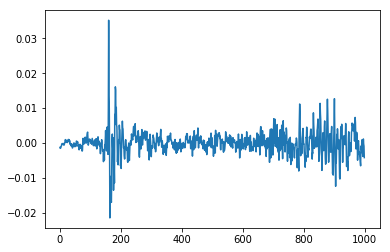

In [3]:
signal_data,sample_rate=librosa.load("input.wav")
plt.plot(signal_data[:1000]);

## Preemphasizing

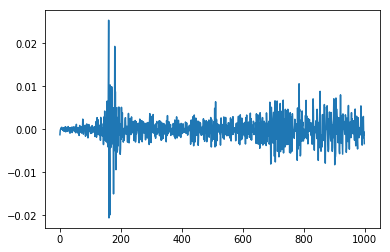

In [4]:
pre_emphasized_data=np.append(signal_data[0],signal_data[1:]-0.97*signal_data[:-1])
plt.plot(pre_emphasized_data[:1000]);

## Framing

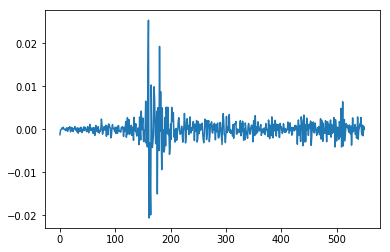

In [5]:
def framing(data,frame_size,frame_stride,frequency_of_signal):  
    length_of_each_frame=int(round(frame_size*frequency_of_signal))
    unique_content_in_each_frame=int(round(frame_stride*frequency_of_signal))
    no_of_frames=int(np.ceil(np.abs(data.size-length_of_each_frame)/unique_content_in_each_frame))+1
    new_length=((no_of_frames-1)*unique_content_in_each_frame)+length_of_each_frame
    padding=np.zeros(new_length-data.size)
    data=np.append(data,padding)
    return data[np.tile(np.arange(0,length_of_each_frame),(no_of_frames,1))+np.tile(range(0,(unique_content_in_each_frame)*no_of_frames,unique_content_in_each_frame),(length_of_each_frame,1)).T]


framed_data=framing(pre_emphasized_data,0.025,0.001,sample_rate)
plt.plot(framed_data[0]);

## Windowing

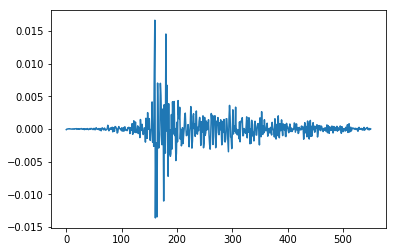

In [6]:
windowed_data= framed_data*np.hamming(len(framed_data[0]))
plt.plot(windowed_data[0]);

# FFT Power spectrum

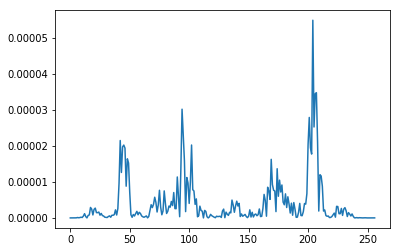

In [7]:
fft_points=512
power_spectrum=(np.absolute(np.fft.rfft(windowed_data,fft_points))**2)/fft_points
plt.plot(power_spectrum[0]);

# Traingular Filter Banks

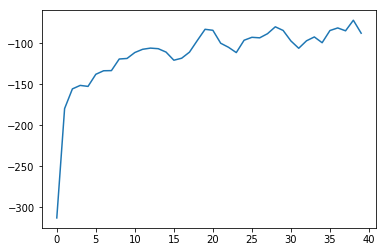

In [8]:
def triangular_filter_banks(frequency,no_of_filters,No_of_points,data):
    low_freq=0
    high_freq_in_mel=2595*np.log10(1+frequency/1400)
    range_of_freq_in_mel=np.linspace(low_freq,high_freq_in_mel,no_of_filters+2)
    range_of_freq_in_hz=((10**(range_of_freq_in_mel/2595))-1)*700
    bins=np.floor((No_of_points+1)*range_of_freq_in_hz/frequency)
    np.zeros(no_of_filters)
    frequency_bank=np.zeros((no_of_filters,int(np.floor((No_of_points/2)+1))))
    for m in range(1,no_of_filters):
        left_side_of_central_freq=int(bins[m-1])
        central_freq=int(bins[m])
        right_side_of_central_freq=int(bins[m+1])
        for each_frequency in  range(left_side_of_central_freq,central_freq):
            frequency_bank[m,each_frequency]=(each_frequency-bins[m-1])/(bins[m]-bins[m-1])
        for each_frequency in range(central_freq,right_side_of_central_freq):
            frequency_bank[m,each_frequency]=(bins[m+1]-each_frequency)/(bins[m+1]-bins[m])
    triangular_filter_bank=np.dot(data,frequency_bank.T)
    triangular_filter_bank=np.where(triangular_filter_bank==0,np.finfo(float).eps,triangular_filter_bank)
    return 20*np.log10(triangular_filter_bank)

triangular_banks=triangular_filter_banks(sample_rate,40,512,power_spectrum)
plt.plot(triangular_banks[0]);

# MFCC features

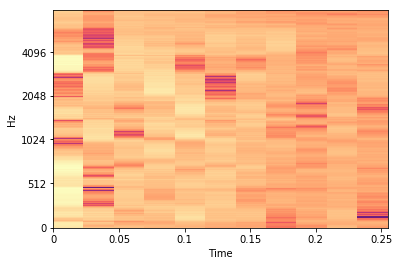

In [9]:
mfcc_features=dct(triangular_banks, type=2, axis=1, norm='ortho')[:, 1 : (12)] 
sound_display.specshow(librosa.power_to_db(mfcc_features,ref=np.max),y_axis='mel', fmax=8000,x_axis='time');